# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns

# Challenge 0 - Import a MySQL table into python:

In this lab, we will twist things up a little. Do you remember your good old friend SQL?
Well, it's time to bring him back and use it in our lab pipeline.

1º- Open the wholesale_customers_data.sql file in MySQL Workbench and run the script into a desired schema.

2º- Create a connection using sqlalchemy from python to mysql and load the table into a variable called *customers*

In [2]:
!pip install mysql-connector


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import mysql.connector
import getpass
saved_password = getpass.getpass()

········


In [3]:
cnx = mysql.connector.connect(user = 'root',password = saved_password, host ='localhost', database = 'wholesale_customer')

In [4]:
cnx.is_connected()

True

In [5]:
cursor = cnx.cursor()

In [6]:
cursor.execute("SELECT * FROM wholesale_customer.wholesale_customers_data")

In [7]:
rows = cursor.fetchall()

In [8]:
customers = pd.DataFrame(rows)

In [9]:
customers

,0,1,2,3,4,5,6,7
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


In [10]:
customers.columns =['Channel', 'Region', 'Fresh', 'Milk','Grocery','Frozen','Detergents_Paper','Delicassen']

In [11]:
customers

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


# Challenge 1 - Describe the Dataset

Your already loaded dataset contains information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

In case of curiosity, the origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [12]:
# FRESH: annual spending (m.u.) on fresh products (Continuous);
# MILK: annual spending (m.u.) on milk products (Continuous);
# GROCERY: annual spending (m.u.) on grocery products (Continuous);
# FROZEN: annual spending (m.u.) on frozen products (Continuous)
# DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
# DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
# CHANNEL: customer Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)
# REGION: customer Region Lisbon, Oporto or Other (Nominal)

In [13]:
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [14]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [15]:
customers['Channel'].value_counts()

1    298
2    142
Name: Channel, dtype: int64

In [16]:
# 1 - Horeca
# 2 - Retail

In [17]:
customers['Region'].value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

In [18]:
# 1 - Lisbon
# 2 - Oporto
# 3 - Other

In [19]:
customers.isnull().sum(axis = 0)

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

Text(0.5, 1.0, 'Correlation Heatmap')

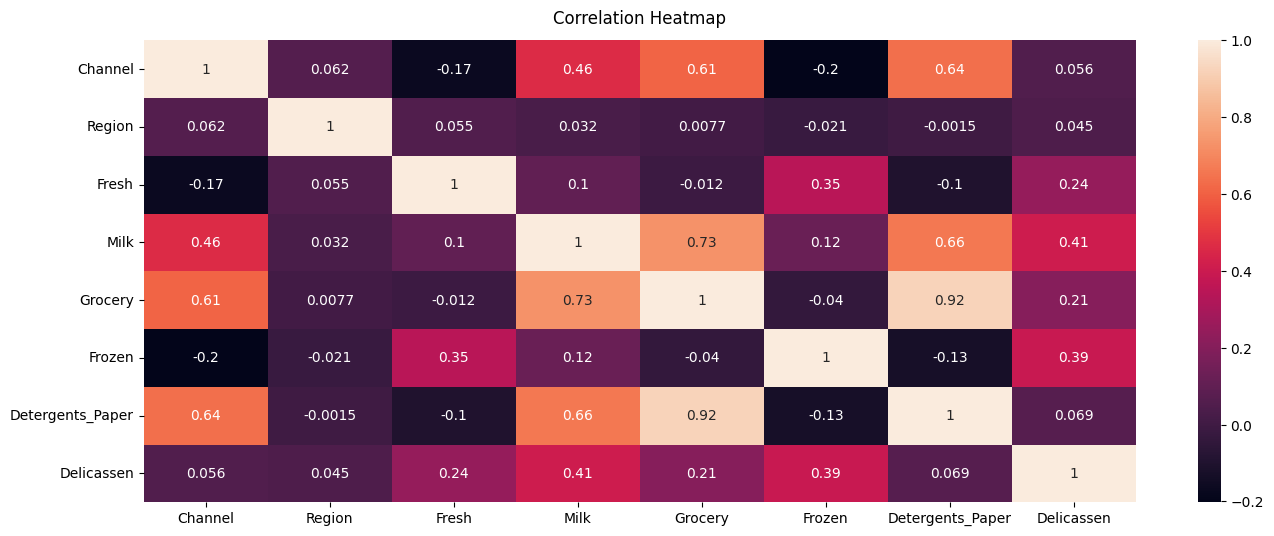

In [20]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(customers.corr(), annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [21]:
# Drop the column with a high corr value = 0,92
customers = customers.drop('Detergents_Paper', axis=1)

In [22]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Channel     440 non-null    int64
 1   Region      440 non-null    int64
 2   Fresh       440 non-null    int64
 3   Milk        440 non-null    int64
 4   Grocery     440 non-null    int64
 5   Frozen      440 non-null    int64
 6   Delicassen  440 non-null    int64
dtypes: int64(7)
memory usage: 24.2 KB


<AxesSubplot: >

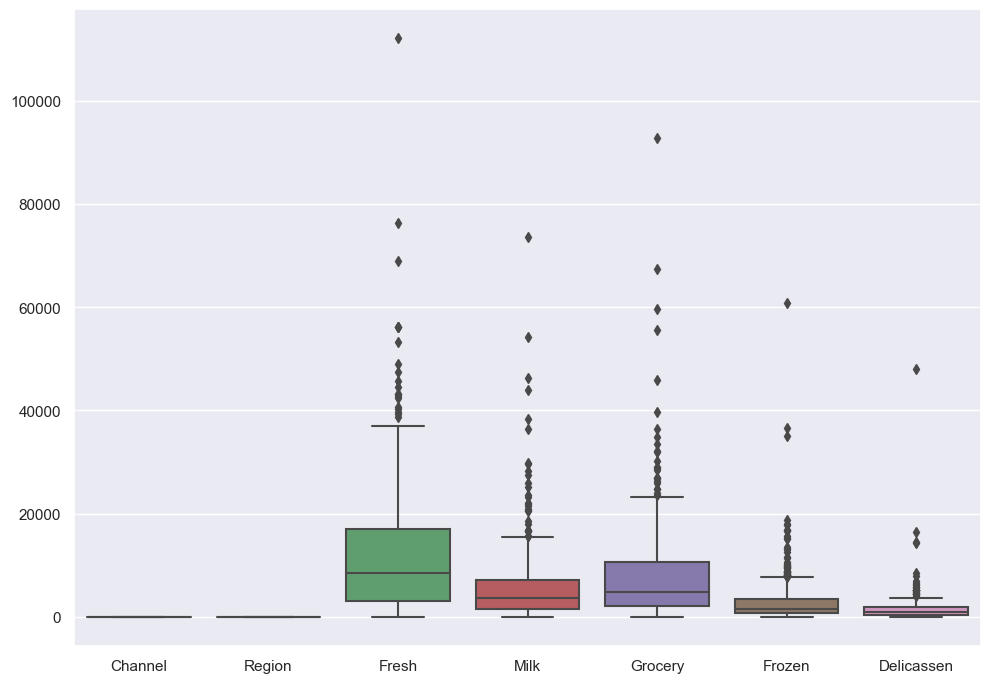

In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.boxplot(data=customers)

In [25]:
customers_new = customers.drop(customers['Fresh'][customers['Fresh']>40000].index)

In [26]:
customers_new = customers_new.drop(customers_new['Fresh'][customers_new['Fresh']>34000].index)

In [27]:
customers_new['Milk'][customers_new['Milk']>15000].sort_values(ascending=False)

86     73498
85     46197
23     36423
56     29892
211    28326
92     27472
171    25862
319    25071
265    23527
251    23133
45     22044
384    21858
49     21412
65     20959
309    20655
28     20484
358    18664
254    17972
325    16784
109    16729
427    16687
216    16599
38     15729
163    15726
437    15488
Name: Milk, dtype: int64

In [28]:
customers_new = customers_new.drop(customers_new['Milk'][customers_new['Milk']>15700].index)

In [29]:
customers_new = customers_new.drop(customers_new['Grocery'][customers_new['Grocery']>25000].index)

In [30]:
customers_new = customers_new.drop(customers_new['Frozen'][customers_new['Frozen']>15000].index)

In [31]:
customers_new = customers_new.drop(customers_new['Delicassen'][customers_new['Delicassen']>10000].index)

In [32]:
len(customers_new)

377

<AxesSubplot: >

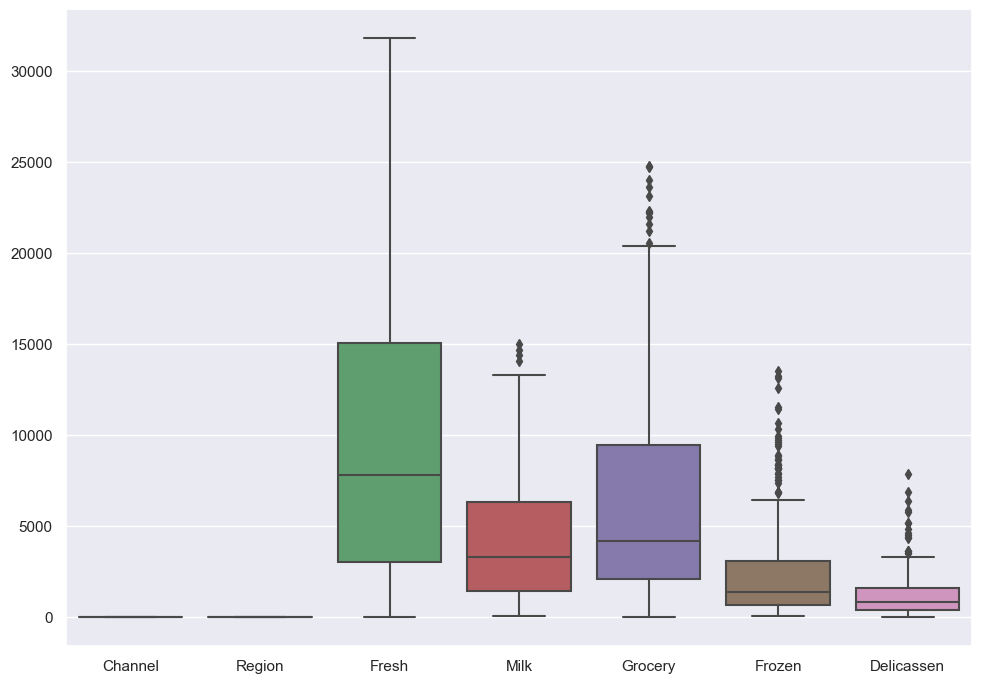

In [33]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.boxplot(data=customers_new)

<AxesSubplot: ylabel='Density'>

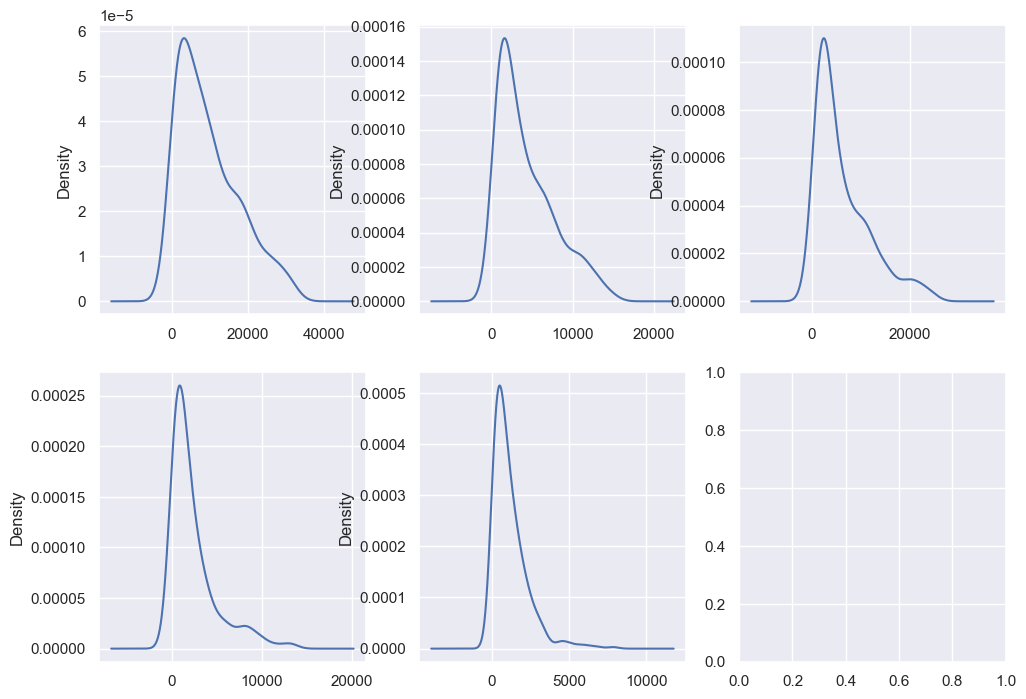

In [34]:
#define subplot layout
fig, axes = plt.subplots(nrows=2, ncols=3)

#add DataFrames to subplots
customers_new['Fresh'].plot(kind='kde',ax=axes[0,0])
customers_new['Milk'].plot(kind='kde',ax=axes[0,1])
customers_new['Grocery'].plot(kind='kde',ax=axes[0,2])
customers_new['Frozen'].plot(kind='kde',ax=axes[1,0])
customers_new['Delicassen'].plot(kind='kde',ax=axes[1,1])

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [35]:
# I did the cleaning on the previous steps

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(customers_new)

customers_scale = scaler.transform(customers_new)

In [39]:
customers_scale

array([[ 1.51888694e+00,  6.01220606e-01,  3.75281945e-01, ...,
         2.31265978e-01, -8.30217812e-01,  1.41882111e-01],
       [ 1.51888694e+00,  6.01220606e-01, -3.25901704e-01, ...,
         5.91595902e-01, -2.43567926e-01,  5.25006270e-01],
       [ 1.51888694e+00,  6.01220606e-01, -4.13862019e-01, ...,
         2.53348978e-01,  1.11580849e-04,  5.83276288e+00],
       ...,
       [-6.58376850e-01,  6.01220606e-01,  2.50357173e+00, ...,
         1.75122270e+00,  4.06648967e+00,  8.99383302e-01],
       [-6.58376850e-01,  6.01220606e-01,  7.80410503e-02, ...,
        -7.25484476e-01, -5.17944229e-01,  8.30280999e-01],
       [-6.58376850e-01,  6.01220606e-01, -8.59411002e-01, ...,
        -6.75573305e-01, -8.86684759e-01, -9.82998411e-01]])

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

C:\Users\adria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\adria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\adria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\adria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

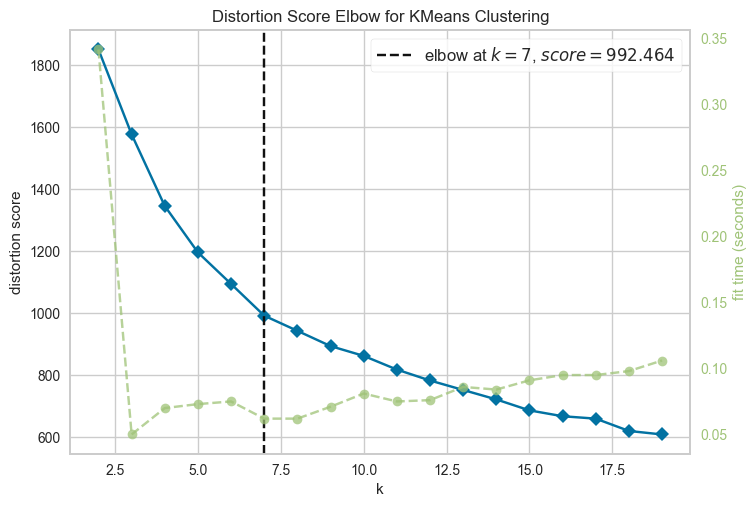

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
from yellowbrick.cluster import KElbowVisualizer

model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,20))
visualizer.fit(customers_scale)
visualizer.poof()

In [40]:
from sklearn import cluster, datasets

In [44]:
kmeans = cluster.KMeans(n_clusters=7)
kmeans.fit(customers_scale)

C:\Users\adria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=7)

Count the values in `labels`.

In [45]:
customers_new['labels'] = kmeans.labels_

customers_new['labels'].value_counts()

1    117
3     73
6     61
0     45
5     35
4     35
2     11
Name: labels, dtype: int64

In [46]:
customers_new.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Delicassen,labels
0,2,3,12669,9656,7561,214,1338,3
1,2,3,7057,9810,9568,1762,1776,3
2,2,3,6353,8808,7684,2405,7844,2
3,1,3,13265,1196,4221,6404,1788,5
4,2,3,22615,5410,7198,3915,5185,2


# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [48]:
dbscan = cluster.DBSCAN(eps=0.5)
dbscan.fit(customers_scale)

DBSCAN()

Count the values in `labels_DBSCAN`.

In [49]:
customers_new['labels_DBSCAN'] = dbscan.labels_

customers_new['labels_DBSCAN'].value_counts()

-1    312
 0     65
Name: labels_DBSCAN, dtype: int64

In [50]:
customers_new.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Delicassen,labels,labels_DBSCAN
0,2,3,12669,9656,7561,214,1338,3,-1
1,2,3,7057,9810,9568,1762,1776,3,-1
2,2,3,6353,8808,7684,2405,7844,2,-1
3,1,3,13265,1196,4221,6404,1788,5,-1
4,2,3,22615,5410,7198,3915,5185,2,-1


# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

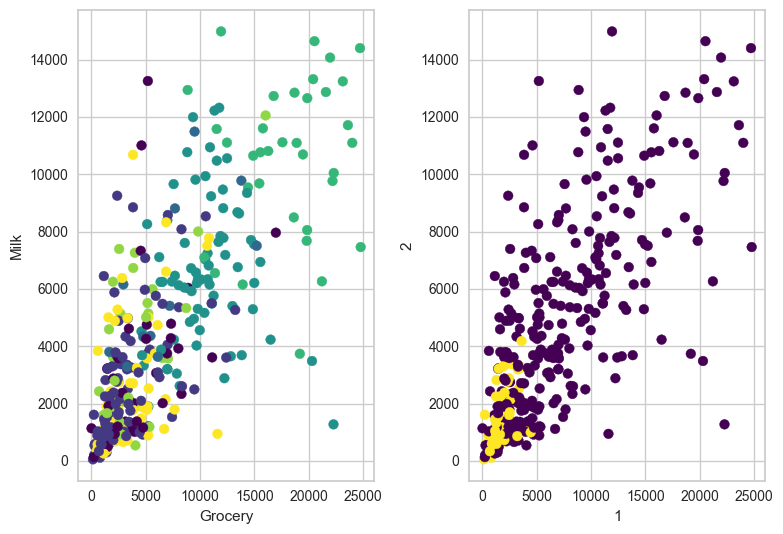

In [64]:
# subplot 1
plt.subplot(1, 2, 1)
plt.scatter(customers_new['Grocery'], customers_new['Milk'],c=customers_new['labels'], cmap='viridis')
plt.xlabel('Grocery')
plt.ylabel('Milk')

# subplot 2
plt.subplot(1, 2, 2)
plt.scatter(customers_new['Grocery'], customers_new['Milk'],c=customers_new['labels_DBSCAN'], cmap='viridis')
plt.xlabel('1')
plt.ylabel('2')

plt.tight_layout()
plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

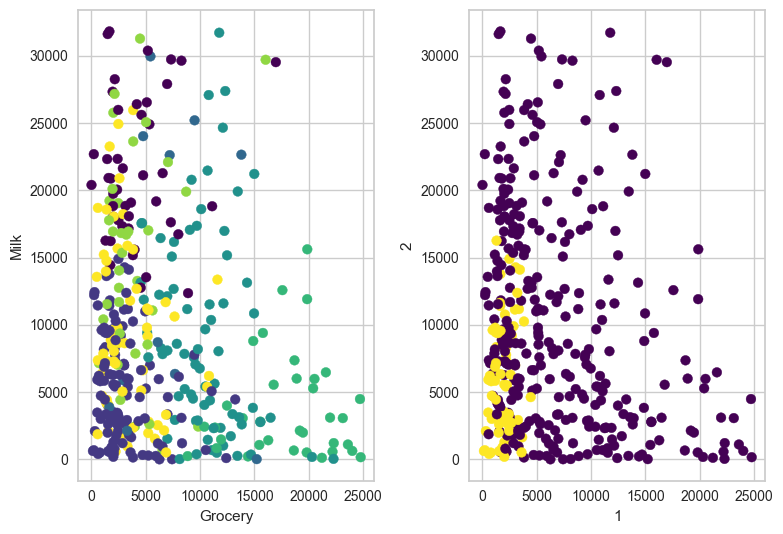

In [65]:
# subplot 1
plt.subplot(1, 2, 1)
plt.scatter(customers_new['Grocery'], customers_new['Fresh'],c=customers_new['labels'], cmap='viridis')
plt.xlabel('Grocery')
plt.ylabel('Milk')

# subplot 2
plt.subplot(1, 2, 2)
plt.scatter(customers_new['Grocery'], customers_new['Fresh'],c=customers_new['labels_DBSCAN'], cmap='viridis')
plt.xlabel('1')
plt.ylabel('2')

plt.tight_layout()
plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

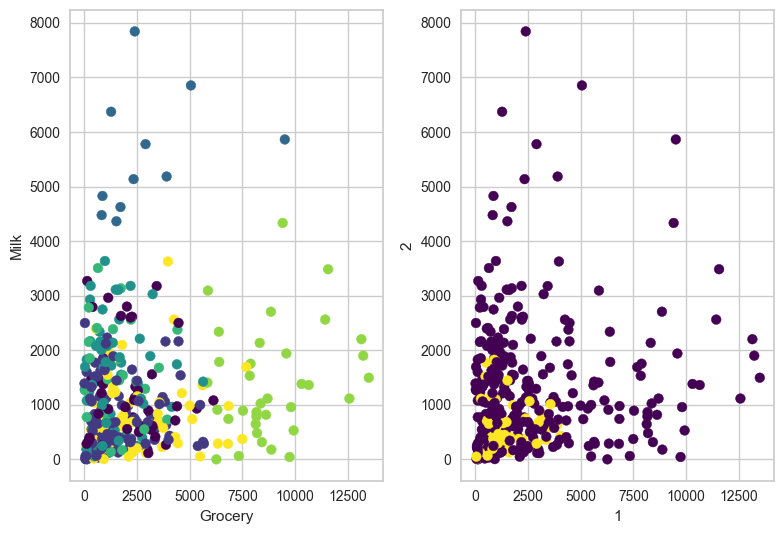

In [66]:
# subplot 1
plt.subplot(1, 2, 1)
plt.scatter(customers_new['Frozen'], customers_new['Delicassen'],c=customers_new['labels'], cmap='viridis')
plt.xlabel('Grocery')
plt.ylabel('Milk')

# subplot 2
plt.subplot(1, 2, 2)
plt.scatter(customers_new['Frozen'], customers_new['Delicassen'],c=customers_new['labels_DBSCAN'], cmap='viridis')
plt.xlabel('1')
plt.ylabel('2')

plt.tight_layout()
plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [70]:
customers_new.groupby(['labels']).mean().mean()

Channel              1.346596
Region               2.477533
Fresh            11106.722161
Milk              5015.448322
Grocery           7163.012690
Frozen            2944.574123
Delicassen        1773.538159
labels_DBSCAN       -0.918681
dtype: float64

In [71]:
customers_new.groupby(['labels_DBSCAN']).mean().mean()

Channel          1.182692
Region           2.716346
Fresh         8274.618269
Milk          3206.616346
Grocery       4546.036218
Frozen        1992.308974
Delicassen     934.485256
labels           2.054808
dtype: float64

Which algorithm appears to perform better?

In [ ]:
# Mean values for KMeans are higher than DBSCAN, so it could mean that the clusters are more differenciated. However,
# I think that DBSCAN could perform better with a higher number of clusters.

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here